In [1]:
import numpy as np

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix

%matplotlib inline
import random

In [2]:
np.random.seed(0)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout, LSTM, Activation, RNN, Bidirectional
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
import pandas as pd
np.random.seed(1)

### Helper functions for Data Loading, normalization, etc

In [3]:
def Reshape_to_input(X, T, Mat_dim):
    """
    reshapes data
    """
   
    [Num_examples, dim] = X.shape
    input_X = X[:,2:].reshape(Num_examples, Mat_dim, T)
    
    return input_X
    

In [4]:
def normalize_towards_mean_train(X):
   # print(X.shape)
    "# Preprocessing: Subtract the mean feature - a question if it is feasible - all features are already in the same scale..."
    " returns the mean and standard deviation from the train set"
    # TODO: try -1 1 normalization
    mean_feat = np.mean(X, axis=1, keepdims=True)
   # print(mean_feat.shape)
    X -= mean_feat
    # Preprocessing: Divide by standard deviation. This ensures that each feature\n",
    # has roughly the same scale.\n",
    std_feat = np.std(X, axis=0, keepdims=True)
    X /= std_feat
    
    return X, mean_feat, std_feat



In [5]:
def normalize_towards_mean_testval(X, mean_feat, std_feat):
   # print(X.shape)
    "# normalize test & val set...\n",
    # TODO: try -1 1 normalization
    X -= mean_feat
    # Preprocessing: Divide by standard deviation. This ensures that each feature\n",
    # has roughly the same scale.\n",
    X /= std_feat
    
    return X

In [6]:
def convert_to_one_hot(inputY, C):
    "Convert Y to one hot representation"
    N= inputY.size
    Y=np.zeros((N,C))
    for i in range (0, inputY.size):
        Y[i, int(inputY[i]-1)] = 1
        
    
    return Y


In [7]:
def compund_model_assess(matrix, val_acc):
    " take the output of models and accuracy, and get the final score"
    num_classes = 3
    ex, dim = matrice_models_for_test.shape
    num_models = dim/3
    
    #binary assessment
    # TO DO
    
    matrice_final =  np.zeros((ex,num_classes))
    for i in range(0,dim,3):
        matrice_final += matrix[:,i:i+3] * val_acc[int(i/3)]
        # weight the model according the validation accuracy of the model
    matrice_final /= num_models
    return matrice_final

In [8]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [9]:
def Gait_model(data):
    """
    Function creating the Gait model's graph.
    
    Arguments:
    input - data

    Returns:
    model -- a model instance in Keras
    """
   
    ### START CODE HERE ###
    gait_data = Input(data.shape, dtype='float32')
    units = 64 
    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    # Be careful, the returned output should be a batch of sequences.

    X = Bidirectional(LSTM(units, return_sequences=True))( gait_data)
    # Add dropout with a probability of 0.5
    X = Dropout(0.5)(X)
    # Propagate X trough another LSTM layer with 128-dimensional hidden state
    # Be careful, the returned output should be a single hidden state, not a batch of sequences.
   
    # Propagate X trough another LSTM layer with 128-dimensional hidden state
    X = Bidirectional(LSTM(units, return_sequences=False),merge_mode='concat')(X)
    # Add dropout with a probability of 0.5
    X = Dropout(0.5)(X)
    # Propagate X through a Dense layer with softmax activation to get back a batch of 5-dimensional vectors.
    X = Dense(3)(X)
    # Add a softmax activation
    X = Activation('softmax')(X)
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs=gait_data, outputs=X)
    
    ### END CODE HERE ###
    
    return model

In [10]:
# load my dataset and parameters from a file
from data_utils_modified import loadfromfolder,Random_Selection_train_test, Selection_train_test

### Model Training

In [11]:
myoptim=Adam(lr=0.0002, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

def get_callbacks(filepath, patience=2):
    es = EarlyStopping(monitor='val_loss', patience=15, verbose=0, mode='min')
    mcp_save = ModelCheckpoint(filepath, save_best_only =True, monitor = 'val_loss', mode ='min')
    reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=15, verbose=1, epsilon=1e-4, mode='min') #epsilon
    return [es, mcp_save, reduce_lr_loss]

In [12]:
# parameters needed
trials = 1
models = 5
epochs = 40
batch_size = 21

units = 64 # actually defind beta_1=0.89, beta_2=0.989, epsilon=1e-08, decay=0.0 inside the funciton of the model - TODO - make it here
path ='data/best'
Files, T, max_dim = loadfromfolder()
#Where Files are names, T - my division into frames and max_dim - feature dimensionality
fRes = open("Results_BiDirCompound_covmat.txt","a+") 
fRes.write("Number of units in LSTM = %d,  Epochs =  %d and batch size =  %d \r\n" % (units, epochs,batch_size))

for file in range(0,len(Files)): 
    name = Files[file]
    t =  T[file]
    dim = int(max_dim[file])
    name_w_path = path +"/"+name
    fRes.write("Experiment %d from file %s \r\n" % (file,name))
    # here all the routine in One cell 
    X_all = pd.read_csv(name_w_path)
    
    # the routine to run the same test N times, randomly shuffling the data
    for j in range(0,trials): 
        fRes.write("Data partinioning random  %d out of %d\r\n\n" % (j, trials))
        persons_testing = np.array([1,9,15,18,20,21,23,25]) # specify which persons can be used for test
        X_train_all, Y_train_all, X_test, Y_test = Selection_train_test(X_all.values, persons_testing)
        Y_test_oh = convert_to_one_hot(Y_test, C = 3)
        
        X_test = Reshape_to_input(X_test, t, dim)
    
        matrice_models_for_test = np.array([], dtype=np.float).reshape(Y_test.size,0) 
        # here is the final matrix, which will save the probability assigned for each class
        Accuracy  = np.zeros(shape=(models))
        val_accuracy  = np.zeros(shape=(models))
        for i in range(0,models):
            
            modelname ='f'+ str(file) +'t'+ str(j) + 'f' + str(i) #define model index
        
            X_train, Y_train, X_val, Y_val, returned_train = Random_Selection_train_test (X_train_all, 11)

            Y_train_oh = convert_to_one_hot(Y_train, C = 3)
            Y_val_oh = convert_to_one_hot(Y_val, C = 3)
            
           
            X_train = Reshape_to_input(X_train, t, dim)
            X_val = Reshape_to_input(X_val, t, dim)
        
        
            model = Gait_model((X_train[0,:,:]))
        
            file_path = 'models/dif_vote/file_{}_model_wts.hdf5'.format(modelname) #create the flders prior to run
            callbacks = get_callbacks(filepath=file_path, patience = 35)
            model.compile(loss='categorical_crossentropy', optimizer=myoptim, metrics=['accuracy'])
              
              
        
            model.fit(X_train, Y_train_oh, epochs=epochs,\
                      batch_size=batch_size, shuffle=True, \
                      validation_data=(X_val, Y_val_oh), callbacks=callbacks)
        
            loss, acc = model.evaluate(X_test, Y_test_oh)
            loss, val_accuracy[i] = model.evaluate(X_val, Y_val_oh)
            probability_assigned = model.predict(X_test) #verbose=1
            matrice_models_for_test = np.hstack([matrice_models_for_test, probability_assigned]) # just stack each matrix horizontally
            Accuracy[i]=acc
            print(acc, val_accuracy[i])
            fRes.write("Final accuracy per trial %f \r\n" % (acc))
        print(Accuracy)
        fRes.write("Final mean accuracy is: %f \r\n" % (np.mean(Accuracy)))
        # calculate final compunt accuracy
        final=compund_model_assess(matrice_models_for_test, val_accuracy)
        Y_test_compound = np.argmax(final, axis=1)+1
        print("Final Model accuracy from %d compound models is %f \r\n\n" % (models, accuracy_score(Y_test,Y_test_compound)))
fRes.close() 


angles_cycles_frames_10t_08f_angles_27persons.csv
Persons for train: 
[ 2.  3.  4.  5.  6.  7.  8. 10. 11. 12. 13. 14. 16. 17. 19. 22. 24. 26.
 27.]
Persons for test: 
[ 1  9 15 18 20 21 23 25]
Persons for train: 
[ 4.  5.  6.  8. 12. 13. 17. 19. 22. 26. 27.]
Persons for test: 
[ 2.  3.  7. 10. 11. 14. 16. 24.]


W0217 21:15:54.349389 139651487283008 callbacks.py:1782] `epsilon` argument is deprecated and will be removed, use `min_delta` instead.


Train on 283 samples, validate on 192 samples
Epoch 1/40
283/283 [==============================] - 7s 25ms/sample - loss: 1.1279 - accuracy: 0.3640 - val_loss: 1.0574 - val_accuracy: 0.5833
Epoch 2/40
283/283 [==============================] - 0s 924us/sample - loss: 1.0442 - accuracy: 0.4382 - val_loss: 1.0032 - val_accuracy: 0.6302
Epoch 3/40
283/283 [==============================] - 0s 955us/sample - loss: 0.9958 - accuracy: 0.4876 - val_loss: 0.9527 - val_accuracy: 0.6406
Epoch 4/40
283/283 [==============================] - 0s 910us/sample - loss: 0.9298 - accuracy: 0.6078 - val_loss: 0.8979 - val_accuracy: 0.6823
Epoch 5/40
283/283 [==============================] - 0s 952us/sample - loss: 0.9005 - accuracy: 0.5936 - val_loss: 0.8450 - val_accuracy: 0.7083
Epoch 6/40
283/283 [==============================] - 0s 945us/sample - loss: 0.8438 - accuracy: 0.6855 - val_loss: 0.7933 - val_accuracy: 0.6979
Epoch 7/40
283/283 [==============================] - 0s 1ms/sample - loss: 0.7

192/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

W0217 21:16:17.280110 139651487283008 callbacks.py:1782] `epsilon` argument is deprecated and will be removed, use `min_delta` instead.


Train on 284 samples, validate on 191 samples
Epoch 1/40
284/284 [==============================] - 7s 26ms/sample - loss: 1.0240 - accuracy: 0.4437 - val_loss: 0.8703 - val_accuracy: 0.5602
Epoch 2/40
284/284 [==============================] - 0s 959us/sample - loss: 0.8068 - accuracy: 0.6373 - val_loss: 0.7186 - val_accuracy: 0.6649
Epoch 3/40
284/284 [==============================] - 0s 932us/sample - loss: 0.6477 - accuracy: 0.7042 - val_loss: 0.6668 - val_accuracy: 0.6806
Epoch 4/40
284/284 [==============================] - 0s 1ms/sample - loss: 0.5520 - accuracy: 0.7465 - val_loss: 0.6069 - val_accuracy: 0.7330
Epoch 5/40
284/284 [==============================] - 0s 1ms/sample - loss: 0.4735 - accuracy: 0.7923 - val_loss: 0.6446 - val_accuracy: 0.7225
Epoch 6/40
284/284 [==============================] - 0s 1ms/sample - loss: 0.4120 - accuracy: 0.8486 - val_loss: 0.5780 - val_accuracy: 0.7539
Epoch 7/40
284/284 [==============================] - 0s 797us/sample - loss: 0.3868 

191/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

W0217 21:16:34.336289 139651487283008 callbacks.py:1782] `epsilon` argument is deprecated and will be removed, use `min_delta` instead.


Train on 266 samples, validate on 209 samples
Epoch 1/40
266/266 [==============================] - 7s 28ms/sample - loss: 1.1629 - accuracy: 0.3346 - val_loss: 1.0781 - val_accuracy: 0.3684
Epoch 2/40
266/266 [==============================] - 0s 986us/sample - loss: 1.0506 - accuracy: 0.4624 - val_loss: 1.0265 - val_accuracy: 0.5694
Epoch 3/40
266/266 [==============================] - 0s 1ms/sample - loss: 1.0569 - accuracy: 0.4474 - val_loss: 0.9924 - val_accuracy: 0.6459
Epoch 4/40
266/266 [==============================] - 0s 1ms/sample - loss: 1.0354 - accuracy: 0.4699 - val_loss: 0.9655 - val_accuracy: 0.6699
Epoch 5/40
266/266 [==============================] - 0s 1ms/sample - loss: 0.9904 - accuracy: 0.5188 - val_loss: 0.9419 - val_accuracy: 0.6842
Epoch 6/40
266/266 [==============================] - 0s 1ms/sample - loss: 0.9533 - accuracy: 0.5827 - val_loss: 0.9212 - val_accuracy: 0.6986
Epoch 7/40
266/266 [==============================] - 0s 1ms/sample - loss: 0.9461 - ac

209/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

W0217 21:16:56.592721 139651487283008 callbacks.py:1782] `epsilon` argument is deprecated and will be removed, use `min_delta` instead.


Train on 278 samples, validate on 197 samples
Epoch 1/40
278/278 [==============================] - 7s 26ms/sample - loss: 1.1108 - accuracy: 0.3633 - val_loss: 1.0651 - val_accuracy: 0.3503
Epoch 2/40
278/278 [==============================] - 0s 1ms/sample - loss: 1.0830 - accuracy: 0.3813 - val_loss: 1.0237 - val_accuracy: 0.4619
Epoch 3/40
278/278 [==============================] - 0s 1ms/sample - loss: 1.0170 - accuracy: 0.5288 - val_loss: 0.9908 - val_accuracy: 0.5685
Epoch 4/40
278/278 [==============================] - 0s 1ms/sample - loss: 0.9916 - accuracy: 0.4964 - val_loss: 0.9666 - val_accuracy: 0.5838
Epoch 5/40
278/278 [==============================] - 0s 1ms/sample - loss: 0.9670 - accuracy: 0.5540 - val_loss: 0.9459 - val_accuracy: 0.5685
Epoch 6/40
278/278 [==============================] - 0s 1ms/sample - loss: 0.9832 - accuracy: 0.5144 - val_loss: 0.9305 - val_accuracy: 0.5635
Epoch 7/40
278/278 [==============================] - 0s 1ms/sample - loss: 0.9533 - accu

197/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

W0217 21:17:19.308227 139651487283008 callbacks.py:1782] `epsilon` argument is deprecated and will be removed, use `min_delta` instead.


Train on 277 samples, validate on 198 samples
Epoch 1/40
277/277 [==============================] - 8s 29ms/sample - loss: 1.1081 - accuracy: 0.3538 - val_loss: 1.0456 - val_accuracy: 0.5455
Epoch 2/40
277/277 [==============================] - 0s 1ms/sample - loss: 1.0557 - accuracy: 0.4440 - val_loss: 1.0124 - val_accuracy: 0.5909
Epoch 3/40
277/277 [==============================] - 0s 1ms/sample - loss: 1.0160 - accuracy: 0.5162 - val_loss: 0.9830 - val_accuracy: 0.6111
Epoch 4/40
277/277 [==============================] - 0s 1ms/sample - loss: 0.9851 - accuracy: 0.5415 - val_loss: 0.9591 - val_accuracy: 0.6465
Epoch 5/40
277/277 [==============================] - 0s 1ms/sample - loss: 1.0146 - accuracy: 0.4874 - val_loss: 0.9353 - val_accuracy: 0.6515
Epoch 6/40
277/277 [==============================] - 0s 1ms/sample - loss: 0.9272 - accuracy: 0.6065 - val_loss: 0.9141 - val_accuracy: 0.6465
Epoch 7/40
277/277 [==============================] - 0s 1ms/sample - loss: 0.9043 - accu

198/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

### Different things to visualize the results

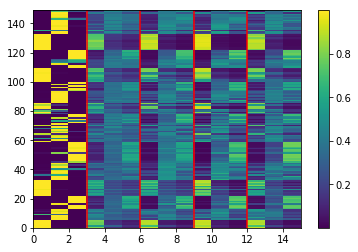

In [13]:
#plt.imshow(matrice_models_for_test, interpolation='nearest', cmap=plt.cm.ocean )
#plt.colorbar()
#plt.show()
plt.pcolor(matrice_models_for_test)
plt.colorbar()
plt.axvline(x=[3], color='r', linestyle='-')
plt.axvline(x=[6], color='r', linestyle='-')
plt.axvline(x=[9], color='r', linestyle='-')
plt.axvline(x=[12], color='r', linestyle='-')
plt.show()

In [14]:
Y_test_compound = np.argmax(final, axis=1)+1
print("Final Model accuracy from %d compound models is %f" % (trials, accuracy_score(Y_test,Y_test_compound)))

Final Model accuracy from 1 compound models is 0.805369


Confusion matrix, without normalization
[[46  7  0]
 [ 3 38  4]
 [ 0 15 36]]


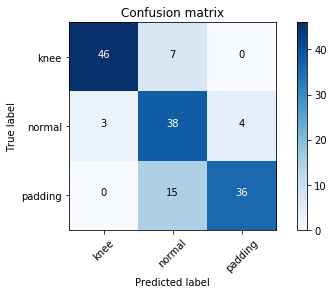

In [15]:
cnf_matrix = confusion_matrix(Y_test,Y_test_compound)
class_names = ['knee', 'normal', 'padding']
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=False,
                      title='Confusion matrix')

In [16]:
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 12, 10)]          0         
_________________________________________________________________
bidirectional_8 (Bidirection (None, 12, 128)           38400     
_________________________________________________________________
dropout_8 (Dropout)          (None, 12, 128)           0         
_________________________________________________________________
bidirectional_9 (Bidirection (None, 128)               98816     
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 387       
_________________________________________________________________
activation_4 (Activation)    (None, 3)                 0   

In [17]:
M = ([39,  1,  0],[ 10, 30,  2],[ 0,  1, 53]) + cnf_matrix

In [18]:
M + cnf_matrix

array([[131,  15,   0],
       [ 16, 106,  10],
       [  0,  31, 125]])

In [19]:
np.ceil(M/3)

array([[29.,  3.,  0.],
       [ 5., 23.,  2.],
       [ 0.,  6., 30.]])

In [20]:
N = ([[39.,  2.,  0.],
       [ 2., 30.,  8.],
       [ 0.,  1., 34.]])